# Project 4
## Goal(s):

Predict if the page is being flipped using a single image.

## Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

## Bonus(es):

Predict if a given sequence of images contains an action of flipping.


In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# # data visualization
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# # Algorithms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import os
import cv2


# Organizing data and initial look

In [2]:
# Directory with our training flip pictures
train_flip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/training/flip')

# Directory with our training not flip pictures
train_notflip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/training/notflip')

# Directory with our test flip pictures
test_flip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/testing/flip')

# Directory with our test not flip pictures
test_notflip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/testing/notflip')

In [3]:
train_flip_names = os.listdir(train_flip_dir)
print(train_flip_names[:10])

train_notflip_names = os.listdir(train_notflip_dir)
print(train_notflip_names[:10])

test_flip_names = os.listdir(test_flip_dir)
print(test_flip_names[:10])

test_notflip_names = os.listdir(test_notflip_dir)
print(test_notflip_names[:10])

['0005_000000020.jpg', '0038_000000009.jpg', '0011_000000019.jpg', '0062_000000023.jpg', '0038_000000021.jpg', '0038_000000035.jpg', '0011_000000025.jpg', '0010_000000017.jpg', '0039_000000013.jpg', '0004_000000012.jpg']
['0005_000000020.jpg', '0011_000000019.jpg', '0005_000000008.jpg', '0038_000000021.jpg', '0011_000000025.jpg', '0039_000000007.jpg', '0010_000000017.jpg', '0039_000000013.jpg', '0010_000000003.jpg', '0004_000000006.jpg']
['0005_000000008.jpg', '0063_000000011.jpg', '0004_000000006.jpg', '0012_000000008.jpg', '0061_000000026.jpg', '0006_000000025.jpg', '0028_000000019.jpg', '0014_000000016.jpg', '0059_000000028.jpg', '0058_000000027.jpg']
['0038_000000009.jpg', '0004_000000012.jpg', '0006_000000025.jpg', '0006_000000019.jpg', '0015_000000018.jpg', '0001_000000009.jpg', '0029_000000017.jpg', '0029_000000003.jpg', '0016_000000020.jpg', '0028_000000024.jpg']


In [7]:
lenTF = len(os.listdir(train_flip_dir))
lenTN = len(os.listdir(train_notflip_dir))
lenTeF = len(os.listdir(test_flip_dir))
lenTeN = len(os.listdir(test_notflip_dir))
print('total training flip images:', lenTF)
print('total training not flip images:', lenTN)
print('total testing flip images:', lenTeF)
print('total testing not flip images:', lenTeN)

total training flip images: 1162
total training not flip images: 1230
total testing flip images: 290
total testing not flip images: 307


In [12]:
print('Not flipped %:', (lenTN+ lenTeN) / (lenTF + lenTN + lenTeF + lenTeN) *100)
print('Testing %:', (lenTeF+ lenTeN) / (lenTF + lenTN + lenTeF + lenTeN) *100)

Not flipped %: 51.421880227500836
Testing %: 19.97323519571763


In [13]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

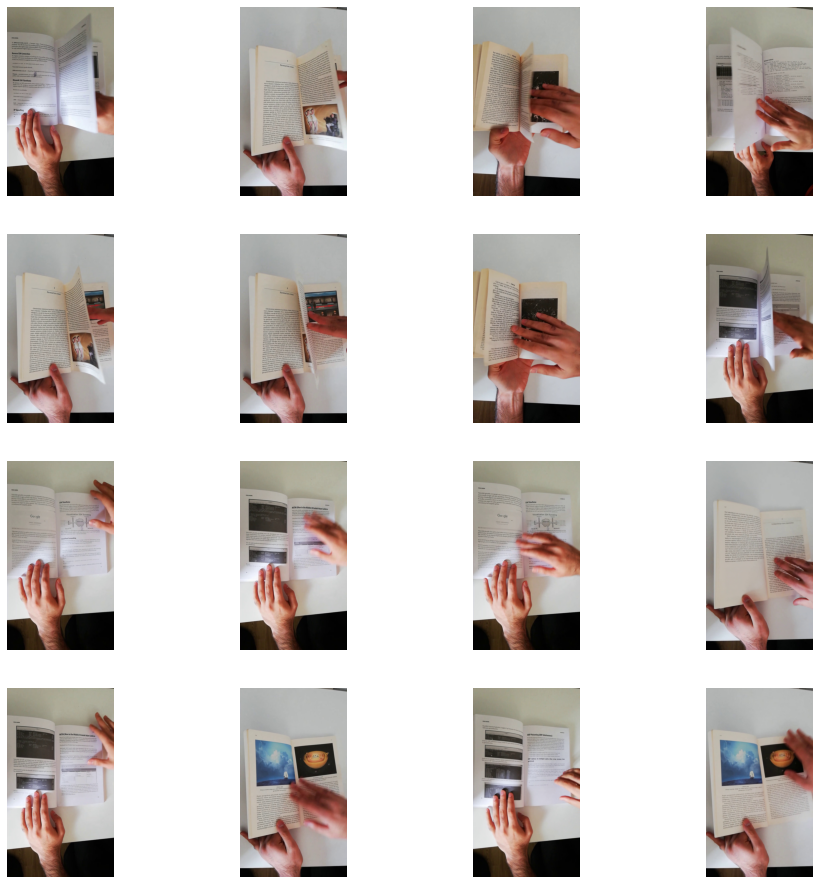

In [14]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_flip_pic = [os.path.join(train_flip_dir, fname) 
                for fname in train_flip_names[pic_index-8:pic_index]]
next_notflip_pic = [os.path.join(train_notflip_dir, fname) 
                for fname in train_notflip_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_flip_pic + next_notflip_pic):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Prepping data for model

In [15]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 299 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/Users/natalie/Dropbox/Apziva/images/training/',  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=239,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 74 using valid_datagen generator
validation_generator = test_datagen.flow_from_directory(
        '/Users/natalie/Dropbox/Apziva/images/testing/',  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=59,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [16]:
def setup_image_predicition(conv, n_dense):
    
    # Define the model architecture
    model = Sequential()
    
    if conv != False:
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
        model.add(MaxPooling2D((2, 2))) 
    
    if conv == 2:
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    if conv == 3:
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    if conv != False:
        model.add(Flatten())
    else:
        model.add(Flatten(input_shape = (200,200,3)))
        
    model.add(Dense(n_dense, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
                  
    print(model.summary())
                  
    model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
    
    return model
                  
def run_image_prediction(validation_generator, train_generator, model, n_epochs, plot=True):
    history = model.fit(train_generator,
      steps_per_epoch=10,  
      epochs=n_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)         
    
    print('accuracy')
    print(model.evaluate(validation_generator))
                  
    preds = model.predict(validation_generator,verbose=1)
                  
    if plot:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        plt.plot(epochs, acc, 'bo', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.figure()

        plt.show()
                
    return preds
                  
def eval_image_prediction(validation_generator, preds, plot=True):
    fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
    roc_auc = auc(fpr, tpr)
    #ROC curve is a probability curve plotting the true-positive rate (TPR) against the false-positive rate (FPR).
    if plot:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    # Convert predictions from probabilities to binary labels
    y_pred = (preds > 0.5).astype(int)

    # Generate true labels for validation set
    y_true = validation_generator.classes

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    print('F1 score:', f1)

    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix:')
    print(cm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 64)                20072512  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20073473 (76.57 MB)
Trainable params: 20073473 (76.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

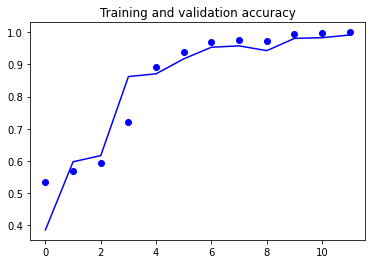

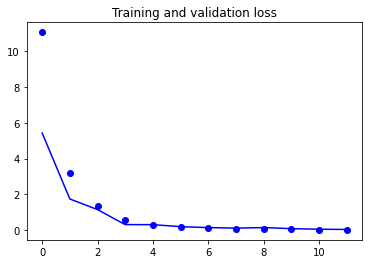

<Figure size 432x288 with 0 Axes>

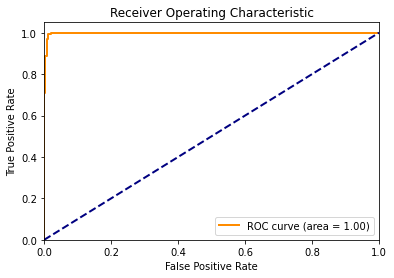

F1 score: 0.9885807504078303
Confusion matrix:
[[287   3]
 [  4 303]]


In [17]:
#model1: run with 1 extra layer
model1 = setup_image_predicition(conv=1, n_dense=64)
preds1 = run_image_prediction(validation_generator, train_generator, model1, n_epochs=12, plot=True)
eval_image_prediction(validation_generator, preds1, plot=True)

Model 1 results - accuracy: 98.8%, F1: 98.8%

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 147456)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

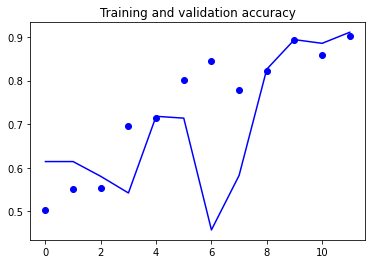

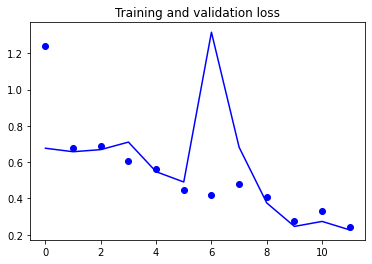

<Figure size 432x288 with 0 Axes>

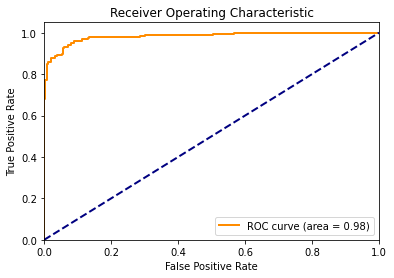

F1 score: 0.8743169398907104
Confusion matrix:
[[288   2]
 [ 67 240]]


In [18]:
#model2: run with 2 extra layer
model2 = setup_image_predicition(conv=2, n_dense=64)
preds2 = run_image_prediction(validation_generator, train_generator, model2, n_epochs=12, plot=True)
eval_image_prediction(validation_generator, preds2, plot=True)

Model 2 results - accuracy: 88.4%, F1: 87.4%

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 128)       36992     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 294912)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

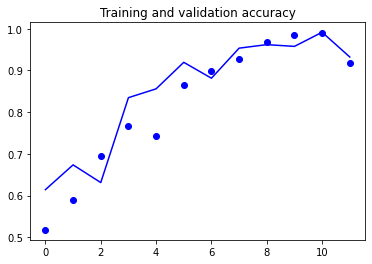

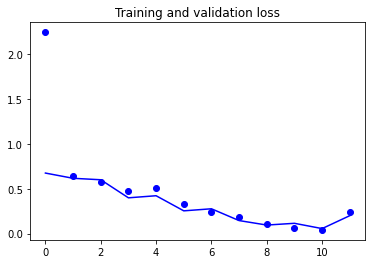

<Figure size 432x288 with 0 Axes>

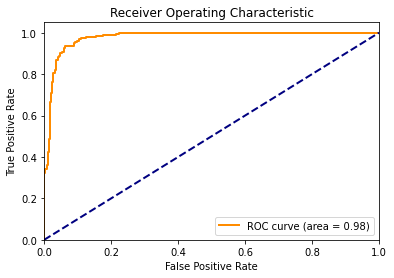

F1 score: 0.9344
Confusion matrix:
[[264  26]
 [ 15 292]]


In [19]:
#model3: run with 3 extra layer
model3 = setup_image_predicition(conv=3, n_dense=64)
preds3 = run_image_prediction(validation_generator, train_generator, model3, n_epochs=12, plot=True)
eval_image_prediction(validation_generator, preds3, plot=True)

Model 3 results - accuracy: 93.1%, F1: 93.4%

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 120000)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                7680064   
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7680129 (29.30 MB)
Trainable params: 7680129 (29.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/12
10/10 [==============================] - 62s 6s/step - loss: 15.5177 - accuracy: 0.5118 - val_loss: 0.6936 - val_accuracy: 0.3856
Epoch 2/12
10/10 [==============================] - 59s 6s/step - loss: 0.6931 - accuracy: 0.5114 - val_loss: 0.6938 - val_accuracy:

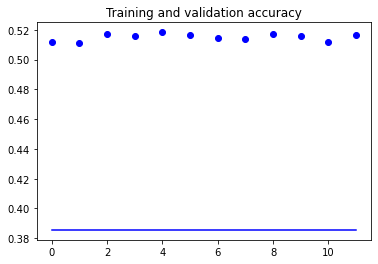

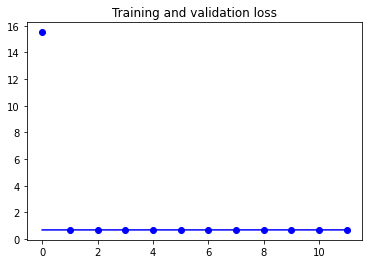

<Figure size 432x288 with 0 Axes>

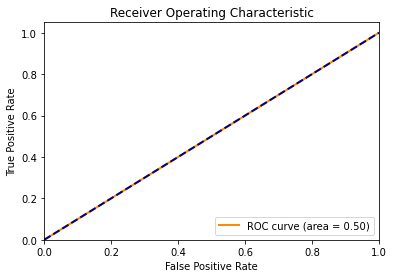

F1 score: 0.6792035398230089
Confusion matrix:
[[  0 290]
 [  0 307]]


In [21]:
#model4: no extra layers
model4 = setup_image_predicition(conv=False, n_dense=64)
preds4 = run_image_prediction(validation_generator, train_generator, model4, n_epochs=12, plot=True)
eval_image_prediction(validation_generator, preds4, plot=True)

Model 4 results - accuracy: 51.4%, F1: 67.9%

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 120000)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               15360128  
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 15360257 (58.59 MB)
Trainable params: 15360257 (58.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/12
10/10 [==============================] - 61s 6s/step - loss: 28.2220 - accuracy: 0.4919 - val_loss: 31.8366 - val_accuracy: 0.3856
Epoch 2/12
10/10 [==============================] - 58s 6s/step - loss: 12.5103 - accuracy: 0.5026 - val_loss: 3.9434 - val_accur

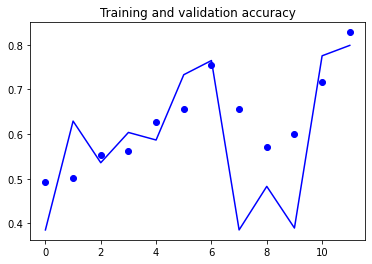

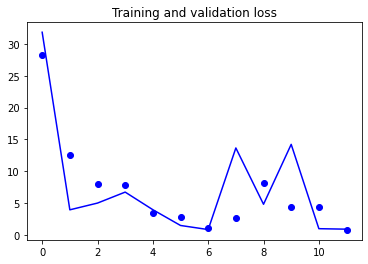

<Figure size 432x288 with 0 Axes>

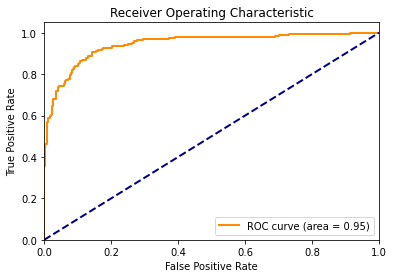

F1 score: 0.8604651162790697
Confusion matrix:
[[205  85]
 [ 11 296]]


In [22]:
#model5: no extra layers, higher density
model5 = setup_image_predicition(conv=False, n_dense=128)
preds5 = run_image_prediction(validation_generator, train_generator, model5, n_epochs=12, plot=True)
eval_image_prediction(validation_generator, preds5, plot=True)

Model 5 results - accuracy: 83.9%, F1: 86%

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 120000)            0         
                                                                 
 dense_12 (Dense)            (None, 192)               23040192  
                                                                 
 dense_13 (Dense)            (None, 1)                 193       
                                                                 
Total params: 23040385 (87.89 MB)
Trainable params: 23040385 (87.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/12
10/10 [==============================] - 62s 6s/step - loss: 49.3124 - accuracy: 0.4942 - val_loss: 0.8333 - val_accuracy: 0.6144
Epoch 2/12
10/10 [==============================] - 77s 8s/step - loss: 0.8759 - accuracy: 0.5113 - val_loss: 0.6941 - val_accurac

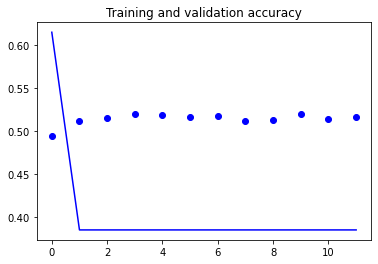

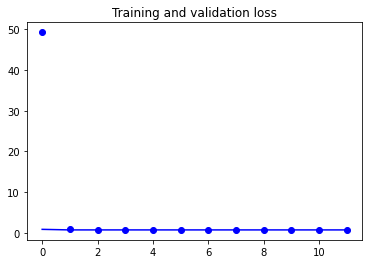

<Figure size 432x288 with 0 Axes>

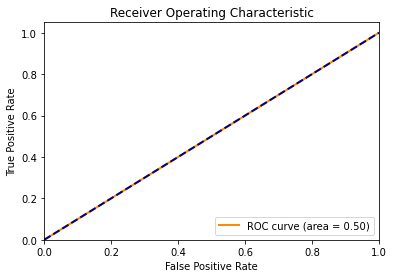

F1 score: 0.6792035398230089
Confusion matrix:
[[  0 290]
 [  0 307]]


In [25]:
#model6: no extra layers, higher density
model6 = setup_image_predicition(conv=False, n_dense=192)
preds6 = run_image_prediction(validation_generator, train_generator, model6, n_epochs=12, plot=True)
eval_image_prediction(validation_generator, preds6, plot=True)

Model 6 results - accuracy: 51.4%, F1: 67.9%

# Results

The dataset seemed balance between the flipped and non flipped images, so no pre-processing or cleaning was that necessary. As for the model building, I wanted to test different combinations of layers and densities to see what led to a better accuracy and good F1 score.

The best accuracy and f1 score were for the first iteration of the model above(model1, 1 convolution layer, 1 maxpooling layer, 2 dense layers) with 98.8% accuracy, F1: 98.8%.

Without the convolution layer(s) and maxpooling, accuracy and f1 score were best when the density was 128, but didn't reach the accuracy of the first model.